In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score
from models.gru import GRU
import scipy

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
batch_size = 5
batch_length = 50000
H_casc = 20
H_out = 40
device = torch.device("cuda:0")
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train
lag = 20
E_no = 2000
I_no = 200
sub_no = 5

In [4]:
base_dir = "/scratch/yjk27/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy").flatten()
S = torch.from_numpy(S)

C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/handsub5_C_syn_e.npy")
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/handsub5_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

In [5]:
S_train = S[:T_train].float()
S_test = S[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model_na = GRU(C_syn_e.to(device), C_syn_i.to(device), H_casc, device)
model_nona = GRU(C_syn_e.to(device), C_syn_i.to(device), H_casc, device)
model_ap = AP_GRU_Lag(H_out, lag, device)

optimizer_na = torch.optim.Adam(model_na.parameters(), lr = 0.0005)
optimizer_nona = torch.optim.Adam(model_nona.parameters(), lr = 0.0005)
optimizer_ap = torch.optim.Adam(model_ap.parameters(), lr = 0.0005)
model_na.to(device).float()
model_nona.to(device).float()
model_ap.to(device).float()

bce_criterion = nn.BCELoss(reduction="mean")

In [7]:
model_na.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60/mono/gru_s5_h20.pt",
                     map_location=device))
model_nona.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_noNA/mono/gru_s5_h20.pt",
                     map_location=device))
model_ap.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms.pt",
                     map_location=device))

<All keys matched successfully>

In [8]:
score_list = np.zeros((iter_no//50))

for i in tnrange(iter_no):
    s = time.time()
    
    model_na.train()
    model_nona.train()
    model_ap.train()
    optimizer_na.zero_grad()
    optimizer_nona.zero_grad()
    optimizer_ap.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_S = S_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    batch_na, _ = model_na(batch_E_neural, batch_I_neural)
    batch_nona, _ = model_nona(batch_E_neural, batch_I_neural)
    
    batch_soma = batch_na + batch_nona
    batch_soma_in = torch.zeros((batch_size, batch_length, lag+1)).to(device) #(lag,1000,50000)
    for j in range(lag):
        batch_soma_in[:,j+1:,j+1] = batch_soma_in[:,j+1:,j+1] + batch_soma[:,:-j-1]
    batch_soma_in[:,:,0] = batch_soma_in[:,:,0] + batch_soma 
    
    S_out = model_ap(batch_soma_in)
    #loss = torch.mean((V_out - batch_V) ** 2)
    loss = bce_criterion(S_out, batch_S)

    loss.backward()
    nn.utils.clip_grad_norm_(model_na.parameters(), 1)
    nn.utils.clip_grad_norm_(model_nona.parameters(), 1)
    nn.utils.clip_grad_norm_(model_ap.parameters(), 1)
    optimizer_na.step()
    optimizer_nona.step()
    optimizer_ap.step()
    s1 = time.time()
    
    if (i%50 == 49) or (i == 0):
        model_na.eval()
        model_nona.eval()
        model_ap.eval()

        test_na, _ = model_na(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_nona, _ = model_nona(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        
        test_soma = test_na + test_nona
        test_soma_in = torch.zeros((1, batch_length, lag+1)).to(device) #(lag,1000,50000)
        for j in range(lag):
            test_soma_in[:,j+1:,j+1] = test_soma_in[:,j+1:,j+1] + test_soma[:,:-j-1]
        test_soma_in[:,:,0] = test_soma_in[:,:,0] + test_soma
        
        test_S_out = model_ap(test_soma_in).flatten()
        #test_loss = torch.mean((test_S_out - S_test)**2).cpu().detach().numpy()
        test_loss = bce_criterion(test_S_out, S_test).cpu().detach().numpy()
        score_list[i//50] = test_loss
        
        print(i, test_loss, s1 - s)

<ipython-input-8-648034f868db>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.0010769516 17.52251148223877
49 0.001101939 16.16802167892456
99 0.0010760628 16.020034313201904
149 0.0011363904 16.146130323410034
199 0.0011041694 16.51260232925415
249 0.001103356 15.992956161499023
299 0.0010894069 16.22067904472351
349 0.0010702348 16.117244720458984
399 0.0010751614 16.105877161026
449 0.0011560109 16.000539541244507
499 0.0010637717 16.320362091064453
549 0.0011119182 15.861346244812012
599 0.0010493882 16.19486975669861
649 0.0010906884 16.58070731163025
699 0.0010945591 15.97835636138916
749 0.0010818439 16.244476079940796
799 0.001073363 16.1535964012146
849 0.0010922624 16.265002727508545
899 0.0011369305 16.067280054092407
949 0.0010626079 16.294339418411255
999 0.0011317389 16.164814710617065
1049 0.0010887898 16.25582242012024
1099 0.0010222099 16.18536376953125
1149 0.001126238 15.99255895614624
1199 0.001101499 16.12905526161194
1249 0.0011165683 16.128421783447266
1299 0.0010548473 15.976870775222778
1349 0.0011169421 16.124593257904053
1399 0.001

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

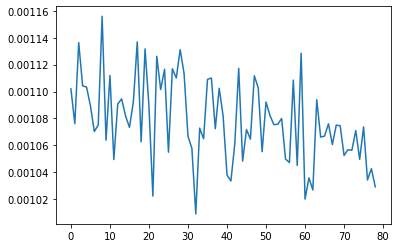

In [9]:
plt.plot(score_list[:79])

(20000.0, 30000.0)

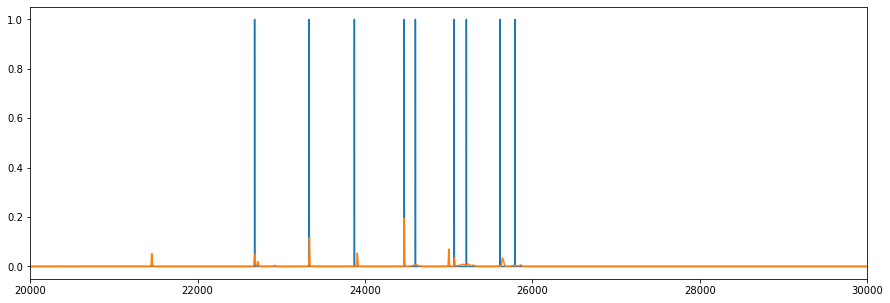

In [12]:
plt.figure(figsize=(15,5))
plt.plot(S_test.cpu().detach().numpy())
plt.plot(test_S_out.cpu().detach().numpy())
#plt.plot()
#plt.plot(batch_V[0].cpu().detach().numpy())
#plt.plot(V[315*50000:316*50000].cpu().detach().numpy())
plt.xlim(20000,30000)

In [13]:
#torch.save(model_ap.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_joint.pt")
#torch.save(model_na.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_na_joint.pt")
#torch.save(model_nona.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_nona_joint.pt")


# Test

In [7]:
model_na.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_na_joint.pt",
                     map_location=device))
model_nona.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_nona_joint.pt",
                     map_location=device))
model_ap.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_joint.pt",
                     map_location=device))

model_na.eval()
model_nona.eval()
model_ap.eval()

AP_GRU_Lag(
  (rnn): GRU(21, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

In [8]:
S_test = S[980*50000:].reshape(20,50000)
test_S_out = np.empty((20,50000))
batch_size = 5
for i in tnrange(20//batch_size):
    batch_E_neural = E_neural[980*50000 + i*batch_size*50000: 980*50000 + (i+1)*batch_size*50000].toarray().reshape(batch_size, 50000, 2000)
    batch_I_neural = I_neural[980*50000 + i*batch_size*50000: 980*50000 + (i+1)*batch_size*50000].toarray().reshape(batch_size, 50000, 200)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    
    batch_na, _ = model_na(batch_E_neural, batch_I_neural)
    batch_nona, _ = model_nona(batch_E_neural, batch_I_neural)
    batch_soma = batch_na + batch_nona
    batch_soma_in = torch.zeros((batch_size, batch_length, lag+1)).to(device) #(lag,1000,50000)
    for j in range(lag):
        batch_soma_in[:,j+1:,j+1] = batch_soma_in[:,j+1:,j+1] + batch_soma[:,:-j-1]
    batch_soma_in[:,:,0] = batch_soma_in[:,:,0] + batch_soma 
    
    S_out = model_ap(batch_soma_in)
    test_S_out[i*batch_size:(i+1)*batch_size] = S_out.cpu().detach().numpy()

<ipython-input-8-6e5ca55d7103>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(20//batch_size):


  0%|          | 0/4 [00:00<?, ?it/s]

(23000.0, 27000.0)

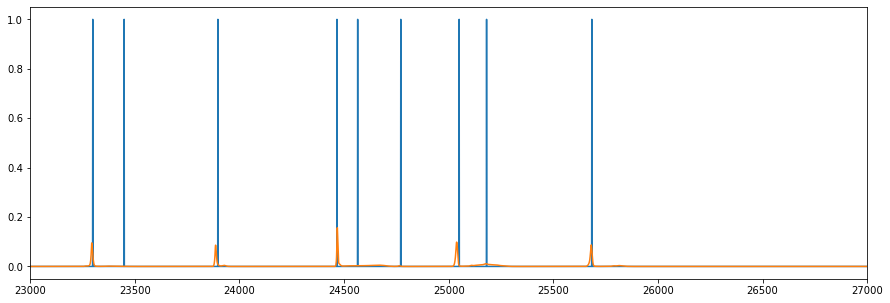

In [10]:
plt.figure(figsize=(15,5))
plt.plot(S_test[0])
plt.plot(test_S_out[0])
plt.xlim(23000,27000)

In [12]:
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_joint.npy", test_S_out)